<a href="https://colab.research.google.com/github/Zangetsu112/IVP_Project/blob/master/MedicalImageForgeryCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.applications import VGG16
conv_base = VGG16(input_shape=(150, 150, 3), include_top=False)
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [2]:
import tensorflow as tf 

base_dir = "/content/drive/MyDrive/IVP_project/forged_image/"

ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    labels='inferred', 
    label_mode='int',  
    image_size=(150, 150), 
    shuffle=True, 
    seed=297,
    validation_split=0.33,
    subset='training' 
)

ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir, 
    labels='inferred', 
    label_mode='int',  
    image_size=(150, 150), 
    shuffle=True, 
    seed=297,
    validation_split=0.33,
    subset='validation'
)

Found 322 files belonging to 2 classes.
Using 216 files for training.
Found 322 files belonging to 2 classes.
Using 106 files for validation.


In [3]:
import numpy as np 
batch_size = 32
def extract_features(datagen, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512)) 
    labels = np.zeros(shape=(sample_count))    
    i = 0
    for inputs_batch, labels_batch in datagen:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch 
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
          break
    return features, labels

In [4]:
train_features, train_labels = extract_features(ds_train, 216)
validation_features, validation_labels = extract_features(ds_validation, 106)

In [5]:
train_features = np.reshape(train_features, (216, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (106, 4 * 4 * 512))

In [48]:
from keras import models, layers 
from tensorflow.keras import optimizers 

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.Adam(lr=1e-3), 
              loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_53 (Dense)            (None, 512)               4194816   
                                                                 
 dropout_32 (Dropout)        (None, 512)               0         
                                                                 
 dense_54 (Dense)            (None, 128)               65664     
                                                                 
 dropout_33 (Dropout)        (None, 128)               0         
                                                                 
 dense_55 (Dense)            (None, 64)                8256      
                                                                 
 dropout_34 (Dropout)        (None, 64)                0         
                                                                 
 dense_56 (Dense)            (None, 1)               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [44]:
history = model.fit(
    train_features, 
    train_labels, 
    epochs=30, 
    batch_size=20, 
    validation_data = (validation_features, validation_labels)
)

Epoch 1/30
11/11 [==============================] - 1s 49ms/step - loss: 6.7655 - accuracy: 0.5509 - val_loss: 6.8791 - val_accuracy: 0.4906
Epoch 2/30
11/11 [==============================] - 0s 32ms/step - loss: 8.7042 - accuracy: 0.5324 - val_loss: 1.7367 - val_accuracy: 0.6509
Epoch 3/30
11/11 [==============================] - 0s 34ms/step - loss: 5.6550 - accuracy: 0.5741 - val_loss: 3.5691 - val_accuracy: 0.3774
Epoch 4/30
11/11 [==============================] - 0s 31ms/step - loss: 4.9343 - accuracy: 0.5463 - val_loss: 0.9707 - val_accuracy: 0.5660
Epoch 5/30
11/11 [==============================] - 0s 32ms/step - loss: 3.4814 - accuracy: 0.5972 - val_loss: 0.6648 - val_accuracy: 0.6415
Epoch 6/30
11/11 [==============================] - 0s 33ms/step - loss: 2.5431 - accuracy: 0.6343 - val_loss: 1.2227 - val_accuracy: 0.5189
Epoch 7/30
11/11 [==============================] - 0s 31ms/step - loss: 3.0503 - accuracy: 0.6111 - val_loss: 0.8035 - val_accuracy: 0.5755
Epoch 8/30
11

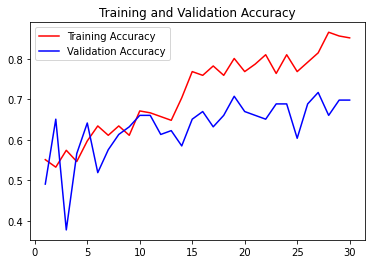

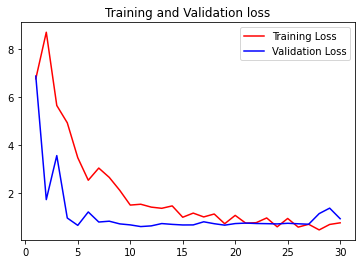

In [45]:
import matplotlib.pyplot as plt 

acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

epochs = [x for x in range(1, len(acc)+1)]

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.legend()
plt.title('Training and Validation loss')
plt.show()